In [1]:
import pandas as pd
import sys
import os
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.stats import zscore
from pydeseq2.default_inference import DefaultInference
from scipy.stats import norm


sys.path.append(os.path.abspath("../../"))
from src.utils.ConvertTextToCsv import TextToCsv
from src.utils.Preprocessing import classify_cancer_type, elimnation_zeros, initialize_DeseqDataSet
from src.utils.plots import box_plot, histogram_log2, PCA_2_variables_log2, PCA_2_variables
%matplotlib inline


In [2]:
df_clincal_data = pd.read_csv("../../data/raw/brca_tcga_pub2015_clinical_data.tsv", sep='\t')
print(len(df_clincal_data.index))

print(f"Number of rows: {df_clincal_data.shape[0]} and number of columns: {df_clincal_data.shape[1]}")

818
Number of rows: 818 and number of columns: 110


In [3]:
df_clincal_data["Disease Free (Months)"]
df_clincal_data["Disease Free Status"]

0      0:DiseaseFree
1      0:DiseaseFree
2      0:DiseaseFree
3      0:DiseaseFree
4      0:DiseaseFree
           ...      
813    0:DiseaseFree
814    0:DiseaseFree
815    0:DiseaseFree
816    0:DiseaseFree
817              NaN
Name: Disease Free Status, Length: 818, dtype: object

In [4]:
df_clincal_data["Overall Survival (Months)"].unique()
df_clincal_data["Overall Survival Status"].unique()


array(['0:LIVING', '1:DECEASED'], dtype=object)

In [5]:
df_clincal_data["ER Status By IHC"].head(20)

0     Positive
1     Positive
2     Positive
3     Positive
4     Negative
5     Positive
6     Positive
7     Negative
8     Positive
9     Positive
10    Negative
11    Positive
12    Positive
13    Negative
14    Negative
15    Positive
16    Negative
17    Negative
18    Positive
19    Negative
Name: ER Status By IHC, dtype: object

In [6]:
df_clincal_data["PR status by ihc"].head(10)

0    Negative
1    Positive
2    Positive
3    Positive
4    Positive
5    Positive
6    Positive
7    Negative
8    Negative
9    Positive
Name: PR status by ihc, dtype: object

In [7]:
df_clincal_data["HER2 ihc score"].dropna().head(20)

2     1.0
4     2.0
6     2.0
7     0.0
8     3.0
10    0.0
14    2.0
15    2.0
16    2.0
17    1.0
18    2.0
20    3.0
21    1.0
23    1.0
24    0.0
27    2.0
29    2.0
30    2.0
31    2.0
32    1.0
Name: HER2 ihc score, dtype: float64

In [8]:
print(df_clincal_data["HER2 fish status"].isna().sum() / len(df_clincal_data))
print(df_clincal_data["HER2 ihc score"].isna().sum() / len(df_clincal_data))


0.6149144254278729
0.4315403422982885


In [9]:
df_clincal_data["HER2 ihc score"].unique()
df_clincal_data.columns.unique()

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'American Joint Committee on Cancer Tumor Stage Code',
       'Brachytherapy first reference point administered total dose',
       ...
       'Somatic Status', 'Staging System', 'Staging System.1',
       'Surgery for positive margins', 'Surgery for positive margins other',
       'Surgical procedure first', 'Tissue Source Site', 'TMB (nonsynonymous)',
       'Person Neoplasm Status', 'Tumor Disease Anatomic Site'],
      dtype='object', length=110)

In [10]:
list_df = classify_cancer_type(df_clinical_data=df_clincal_data)

luminal_A = [x for x in list_df if x == "Luminal A"]
luminal_B = [x for x in list_df if x == "Luminal B"]
HER2_enriched = [x for x in list_df if x == "HER2-enriched"]
TNBC = [x for x in list_df if x == "TNBC"]
UNK = [x for x in list_df if x == "<UNK>"]

print(f"Luminal A: {len(luminal_A)} - Total(%): {len(luminal_A) / len(df_clincal_data):.2f}")
print(f"Luminal B: {len(luminal_B)} - Total(%):{len(luminal_B) / len(df_clincal_data):.2f}")
print(f"HER2-enriched: {len(HER2_enriched)} - Total(%):{len(HER2_enriched) / len(df_clincal_data):.2f}")
print(f"TNBC: {len(TNBC)} - Total(%){len(TNBC) / len(df_clincal_data):.2f} ")
print(f"UNK: {len(UNK)} - Total(%) {len(UNK) / len(df_clincal_data):.2f}")

df_clincal_data["Tumor-Cancer"] = list_df



Luminal A: 330 - Total(%): 0.40
Luminal B: 81 - Total(%):0.10
HER2-enriched: 23 - Total(%):0.03
TNBC: 85 - Total(%)0.10 
UNK: 299 - Total(%) 0.37


In [11]:
df_clincal_data["Tumor-Cancer"].unique()

array(['<UNK>', 'Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'],
      dtype=object)

In [12]:
#Luminal A 
luminal_a_dataset = df_clincal_data[df_clincal_data["Tumor-Cancer"] == "Luminal A"]

#Luminal B
luminal_b_dataset = df_clincal_data[df_clincal_data["Tumor-Cancer"] == "Luminal B"]

In [13]:
df_mRNA = pd.read_csv("../../data/raw/data_mrna_seq_v2_rsem.txt", header=None)

In [ ]:
df_mRNA_transformed = TextToCsv("../../data/raw/data_mrna_seq_v2_rsem.txt")

Clincal Data Set

In [15]:
df_clincal_data["Tumor-Cancer"].unique()

array(['<UNK>', 'Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'],
      dtype=object)

mRNA seq

In [16]:
df_mRNA_transformed = df_mRNA_transformed.drop(columns=["Hugo_Symbol", "Entrez_Gene_Id"], axis=0)


In [17]:
df_mrna = df_mRNA_transformed.T.reset_index()

In [18]:
df_mRNA_final = df_mrna.rename(columns={"index":"Sample ID"})
df_mRNA_final

,Sample ID,0,1,2,3,4,5,6,7,8,...,20430,20431,20432,20433,20434,20435,20436,20437,20438,20439
0,TCGA-A1-A0SB-01,14.3935,116.3870,279.7612,0.4505,0.0,0.9010,0.9010,1.8020,0.0000,...,95.9568,519.4279,1415.9252,19.3716,1364.5681,6186.7327,1931.2986,1436.1978,552.3144,0.0000
1,TCGA-A1-A0SD-01,11.3241,60.2630,83.6986,0.3308,0.0,0.6616,0.3308,4.6315,0.3308,...,96.2700,578.2814,1225.7051,33.0825,868.0837,3559.6725,1278.9678,1195.6000,86.0144,0.0000
2,TCGA-A1-A0SE-01,4.4426,153.1452,74.7018,0.0000,0.0,0.0000,0.9872,5.5944,0.3291,...,95.4340,726.6146,1018.8400,57.5895,960.5923,3007.8157,926.3677,1075.4422,866.1456,0.0000
3,TCGA-A1-A0SF-01,10.7401,141.1933,314.4482,0.0000,0.0,0.0000,2.9988,9.4249,0.0000,...,74.1138,533.3625,1053.4444,94.6772,881.2262,5343.4779,934.3482,508.0867,52.2652,0.8568
4,TCGA-A1-A0SH-01,3.0048,79.8003,95.7054,0.0000,0.0,0.0000,0.3612,3.9727,0.0000,...,87.7601,581.0946,801.3977,19.8634,1353.2389,5464.9614,1312.7898,1001.1151,455.7746,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,TCGA-MS-A51U-01,7.9343,150.6834,540.4278,1.5649,0.0,0.5216,0.0000,6.2598,0.0000,...,79.2906,443.9228,1083.4637,40.6886,858.1116,4930.6208,2212.8326,665.6234,249.8696,0.0000
813,TCGA-OL-A66H-01,2.2519,115.3378,338.1985,2.0851,0.0,0.0000,2.0851,4.1701,0.0000,...,45.4545,747.7064,903.6697,10.4254,634.2786,4163.4696,1251.8766,773.1443,5.8382,0.0000
814,TCGA-OL-A66I-01,1.2603,158.3599,210.7460,0.4173,0.0,2.0866,2.5039,2.5039,0.4173,...,61.3459,334.2723,933.1247,206.1555,479.0819,6621.1789,649.3479,780.3860,47.1570,0.0000
815,TCGA-OL-A66J-01,5.0428,124.6327,323.1185,0.4507,0.0,0.0000,8.1118,5.8585,3.1546,...,45.5160,797.6566,1038.3055,13.9703,683.1906,5216.7643,1408.7427,713.3844,567.3727,0.0000


In [19]:
df_merged = pd.merge(df_mRNA_final, df_clincal_data, right_on="Sample ID", left_on="Sample ID")
df_merged

,Sample ID,0,1,2,3,4,5,6,7,8,...,Staging System,Staging System.1,Surgery for positive margins,Surgery for positive margins other,Surgical procedure first,Tissue Source Site,TMB (nonsynonymous),Person Neoplasm Status,Tumor Disease Anatomic Site,Tumor-Cancer
0,TCGA-A1-A0SB-01,14.3935,116.3870,279.7612,0.4505,0.0,0.9010,0.9010,1.8020,0.0000,...,Sentinel node biopsy alone,NaN,NaN,NaN,Lumpectomy,A1,0.600000,TUMOR FREE,Breast,<UNK>
1,TCGA-A1-A0SD-01,11.3241,60.2630,83.6986,0.3308,0.0,0.6616,0.3308,4.6315,0.3308,...,Sentinel lymph node biopsy plus axillary disse...,NaN,Lumpectomy,NaN,Lumpectomy,A1,1.000000,NaN,Breast,<UNK>
2,TCGA-A1-A0SE-01,4.4426,153.1452,74.7018,0.0000,0.0,0.0000,0.9872,5.5944,0.3291,...,Sentinel lymph node biopsy plus axillary disse...,NaN,NaN,NaN,Modified Radical Mastectomy,A1,0.700000,TUMOR FREE,Breast,Luminal A
3,TCGA-A1-A0SF-01,10.7401,141.1933,314.4482,0.0000,0.0,0.0000,2.9988,9.4249,0.0000,...,Sentinel lymph node biopsy plus axillary disse...,NaN,NaN,NaN,Modified Radical Mastectomy,A1,1.266667,TUMOR FREE,Breast,<UNK>
4,TCGA-A1-A0SH-01,3.0048,79.8003,95.7054,0.0000,0.0,0.0000,0.3612,3.9727,0.0000,...,Sentinel node biopsy alone,NaN,NaN,NaN,Lumpectomy,A1,2.600000,TUMOR FREE,Breast,<UNK>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,TCGA-MS-A51U-01,7.9343,150.6834,540.4278,1.5649,0.0,0.5216,0.0000,6.2598,0.0000,...,NaN,NaN,NaN,NaN,Modified Radical Mastectomy,MS,0.433333,WITH TUMOR,Breast,Luminal A
813,TCGA-OL-A66H-01,2.2519,115.3378,338.1985,2.0851,0.0,0.0000,2.0851,4.1701,0.0000,...,NaN,NaN,NaN,NaN,Lumpectomy,OL,0.700000,TUMOR FREE,Breast,Luminal A
814,TCGA-OL-A66I-01,1.2603,158.3599,210.7460,0.4173,0.0,2.0866,2.5039,2.5039,0.4173,...,Sentinel node biopsy alone,NaN,NaN,NaN,Lumpectomy,OL,0.966667,TUMOR FREE,Breast,TNBC
815,TCGA-OL-A66J-01,5.0428,124.6327,323.1185,0.4507,0.0,0.0000,8.1118,5.8585,3.1546,...,Sentinel node biopsy alone,NaN,NaN,NaN,Lumpectomy,OL,1.733333,TUMOR FREE,Breast,Luminal A


In [37]:
comparation_df = df_merged.loc[
    df_merged["Tumor-Cancer"].isin(["Luminal A", "Luminal B", "TNBC", "HER2_enriched", "UNK"]),
    ["Tumor-Cancer"] + list(df_merged.columns[1:20441])
]



comparation_df

,Tumor-Cancer,0,1,2,3,4,5,6,7,8,...,20430,20431,20432,20433,20434,20435,20436,20437,20438,20439
2,Luminal A,4.4426,153.1452,74.7018,0.0000,0.0,0.0000,0.9872,5.5944,0.3291,...,95.4340,726.6146,1018.8400,57.5895,960.5923,3007.8157,926.3677,1075.4422,866.1456,0.0000
6,Luminal A,4.9419,134.8733,63.6488,0.3658,0.0,0.0000,0.3658,4.7554,0.0000,...,83.7677,2731.4129,834.3850,51.2117,1092.6383,3032.0988,958.3905,718.7929,43.5299,0.0000
7,TNBC,28.8560,1119.1932,166.7192,0.3152,0.0,1.8910,0.0000,3.4668,0.0000,...,69.0199,610.1481,1775.6067,158.5251,1380.7123,591.2386,1798.9285,1335.6445,49.4800,0.0000
8,Luminal B,7.6484,119.4760,80.8081,0.3157,0.0,0.0000,0.3157,5.6818,0.6313,...,60.6061,546.0859,1014.2045,39.4571,1410.0379,4570.0758,1182.4495,1454.8611,1169.5076,0.0000
10,TNBC,9.4309,190.5983,140.0949,0.0000,0.0,0.0000,0.7297,5.4725,0.0000,...,26.9974,292.2291,1040.4962,241.5177,681.5031,3473.9146,721.9993,1414.0825,15.3229,0.3648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,Luminal A,7.9343,150.6834,540.4278,1.5649,0.0,0.5216,0.0000,6.2598,0.0000,...,79.2906,443.9228,1083.4637,40.6886,858.1116,4930.6208,2212.8326,665.6234,249.8696,0.0000
813,Luminal A,2.2519,115.3378,338.1985,2.0851,0.0,0.0000,2.0851,4.1701,0.0000,...,45.4545,747.7064,903.6697,10.4254,634.2786,4163.4696,1251.8766,773.1443,5.8382,0.0000
814,TNBC,1.2603,158.3599,210.7460,0.4173,0.0,2.0866,2.5039,2.5039,0.4173,...,61.3459,334.2723,933.1247,206.1555,479.0819,6621.1789,649.3479,780.3860,47.1570,0.0000
815,Luminal A,5.0428,124.6327,323.1185,0.4507,0.0,0.0000,8.1118,5.8585,3.1546,...,45.5160,797.6566,1038.3055,13.9703,683.1906,5216.7643,1408.7427,713.3844,567.3727,0.0000


In [21]:
print(comparation_df.shape[0])
print(comparation_df.shape[1])

zeros_reduced_df = elimnation_zeros(comparation_df)
print(zeros_reduced_df.shape[0])

411
20441
Max of zeros per row in the dataset: 411
Avg of zeros per row in the dataset: 58.75865949119374
Median of zeros per row in the dataset: 0.0
Min of zeros per row in the dataset: 0
After the 0 elimination: 16299
411


In [22]:
zeros_reduced_df

,Tumor-Cancer,0,1,2,7,14,17,18,19,22,...,20429,20430,20431,20432,20433,20434,20435,20436,20437,20438
2,Luminal A,4.4426,153.1452,74.7018,5.5944,299.7943,476.1826,100.3702,192.8194,70.9305,...,810.8597,95.4340,726.6146,1018.8400,57.5895,960.5923,3007.8157,926.3677,1075.4422,866.1456
6,Luminal A,4.9419,134.8733,63.6488,4.7554,636.1225,391.0380,4.7554,226.7801,130.9410,...,420.6676,83.7677,2731.4129,834.3850,51.2117,1092.6383,3032.0988,958.3905,718.7929,43.5299
8,Luminal B,7.6484,119.4760,80.8081,5.6818,183.7121,496.2121,26.5152,307.4937,102.7241,...,505.0505,60.6061,546.0859,1014.2045,39.4571,1410.0379,4570.0758,1182.4495,1454.8611,1169.5076
12,Luminal A,6.9810,108.0428,219.0967,10.3011,196.9097,586.3708,55.4675,183.4905,127.3138,...,497.2266,66.9572,368.8590,1082.4089,44.3740,786.4501,2560.6181,1076.0697,895.0079,93.1062
15,Luminal A,11.5874,119.8406,262.2476,10.5044,885.9911,399.8913,15.9377,209.6278,67.5251,...,1162.0031,106.4928,3220.5017,1341.3022,80.0507,813.1848,2985.4206,652.3590,442.2711,228.1989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,Luminal A,14.1288,117.0300,307.2124,3.9898,156.5985,470.7930,78.2993,498.7862,62.0908,...,1164.0158,77.3018,540.1153,1191.9442,345.6139,838.3507,2721.5227,1247.8010,1093.1973,25.9335
812,Luminal A,7.9343,150.6834,540.4278,6.2598,217.5274,622.8482,63.1195,362.5874,144.1210,...,294.2097,79.2906,443.9228,1083.4637,40.6886,858.1116,4930.6208,2212.8326,665.6234,249.8696
813,Luminal A,2.2519,115.3378,338.1985,4.1701,402.0017,943.2861,18.3486,51.2469,160.6005,...,536.6972,45.4545,747.7064,903.6697,10.4254,634.2786,4163.4696,1251.8766,773.1443,5.8382
815,Luminal A,5.0428,124.6327,323.1185,5.8585,1139.2519,543.9387,22.5327,267.0482,39.8197,...,465.0744,45.5160,797.6566,1038.3055,13.9703,683.1906,5216.7643,1408.7427,713.3844,567.3727


In [23]:
zeros_reduced_df.iloc[:,1:] = zeros_reduced_df.iloc[:, 1:].astype(int)


In [24]:
zeros_reduced_df

,Tumor-Cancer,0,1,2,7,14,17,18,19,22,...,20429,20430,20431,20432,20433,20434,20435,20436,20437,20438
2,Luminal A,4.0,153.0,74.0,5.0,299.0,476.0,100.0,192.0,70.0,...,810.0,95.0,726.0,1018.0,57.0,960.0,3007.0,926.0,1075.0,866.0
6,Luminal A,4.0,134.0,63.0,4.0,636.0,391.0,4.0,226.0,130.0,...,420.0,83.0,2731.0,834.0,51.0,1092.0,3032.0,958.0,718.0,43.0
8,Luminal B,7.0,119.0,80.0,5.0,183.0,496.0,26.0,307.0,102.0,...,505.0,60.0,546.0,1014.0,39.0,1410.0,4570.0,1182.0,1454.0,1169.0
12,Luminal A,6.0,108.0,219.0,10.0,196.0,586.0,55.0,183.0,127.0,...,497.0,66.0,368.0,1082.0,44.0,786.0,2560.0,1076.0,895.0,93.0
15,Luminal A,11.0,119.0,262.0,10.0,885.0,399.0,15.0,209.0,67.0,...,1162.0,106.0,3220.0,1341.0,80.0,813.0,2985.0,652.0,442.0,228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,Luminal A,14.0,117.0,307.0,3.0,156.0,470.0,78.0,498.0,62.0,...,1164.0,77.0,540.0,1191.0,345.0,838.0,2721.0,1247.0,1093.0,25.0
812,Luminal A,7.0,150.0,540.0,6.0,217.0,622.0,63.0,362.0,144.0,...,294.0,79.0,443.0,1083.0,40.0,858.0,4930.0,2212.0,665.0,249.0
813,Luminal A,2.0,115.0,338.0,4.0,402.0,943.0,18.0,51.0,160.0,...,536.0,45.0,747.0,903.0,10.0,634.0,4163.0,1251.0,773.0,5.0
815,Luminal A,5.0,124.0,323.0,5.0,1139.0,543.0,22.0,267.0,39.0,...,465.0,45.0,797.0,1038.0,13.0,683.0,5216.0,1408.0,713.0,567.0


In [25]:
print(f"Genes: {zeros_reduced_df.shape[0]}, Samples: {zeros_reduced_df.shape[1]}")



Genes: 411, Samples: 16299


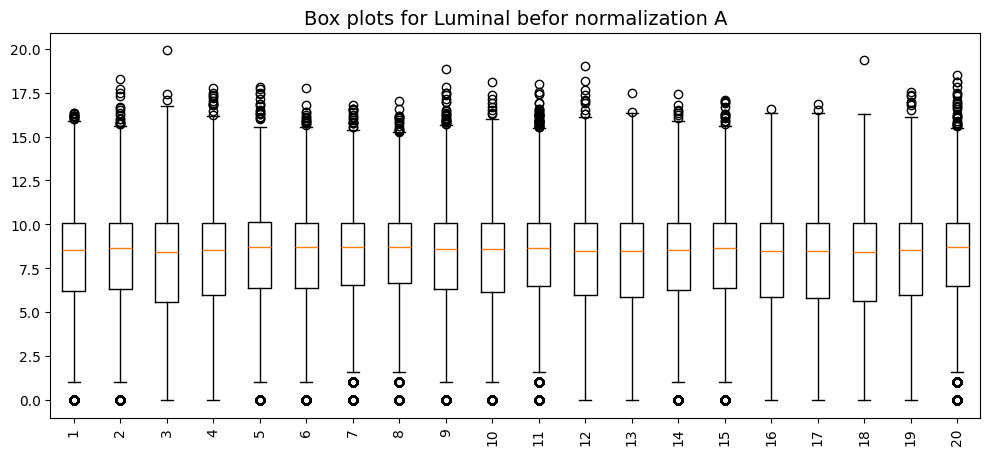

In [26]:
box_plot(df=zeros_reduced_df, title="Box plots for Luminal befor normalization A", type_cancer="Luminal A")

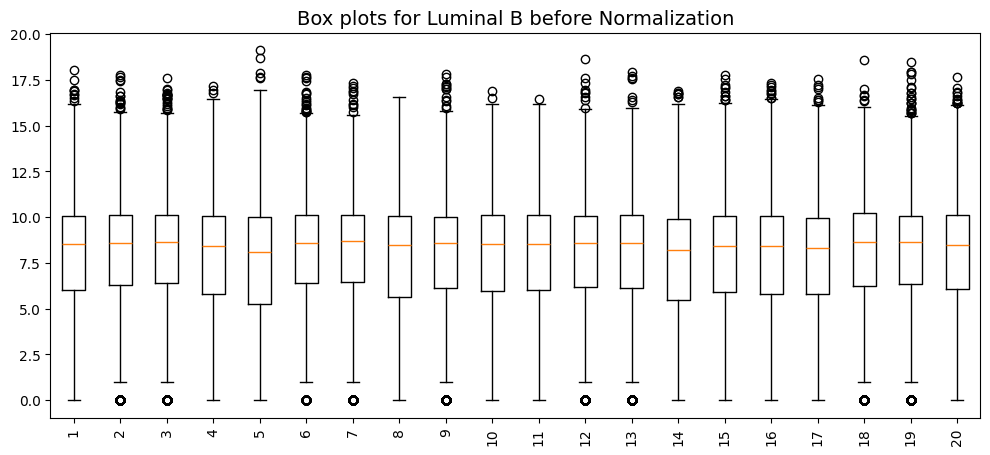

In [27]:
box_plot(df=zeros_reduced_df, title="Box plots for Luminal B before Normalization", type_cancer="Luminal B")

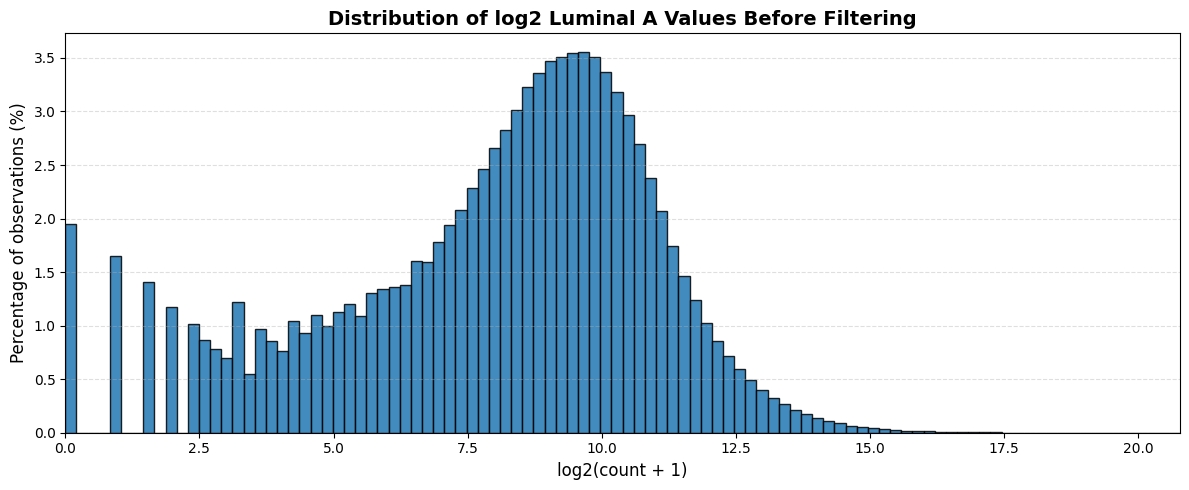

In [28]:
histogram_log2(df=zeros_reduced_df, title="Luminal A", type_cancer="Luminal A")

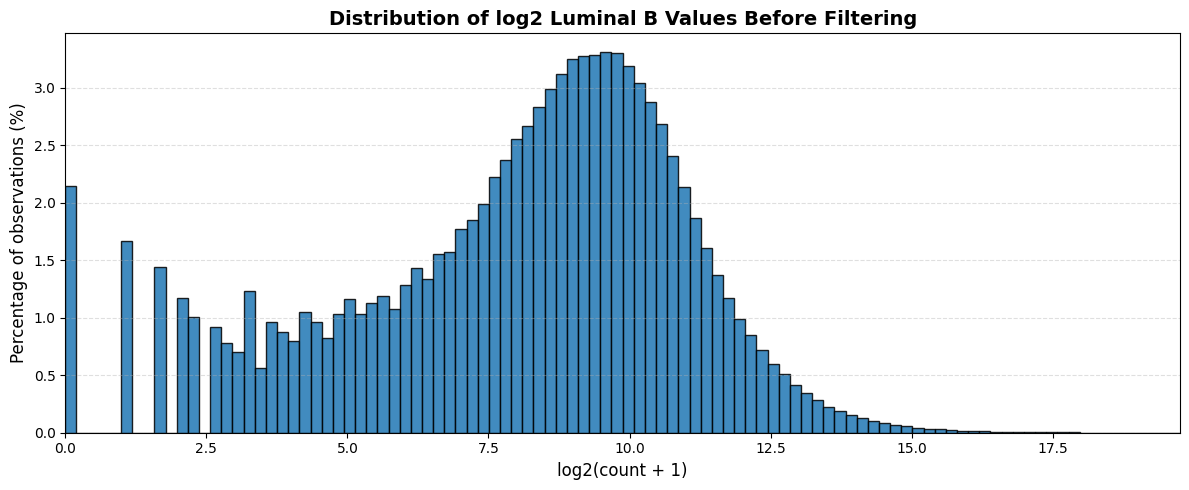

In [29]:
histogram_log2(df=zeros_reduced_df, title="Luminal B", type_cancer="Luminal B")

In [30]:
PCA_2_variables_log2(df=zeros_reduced_df, cancer_type_one="Luminal A", cancer_type_two="Luminal B")
PCA_2_variables(df=zeros_reduced_df, cancer_type_one="Luminal A", cancer_type_two="Luminal B")


Split for making the Conditions for Deseq

In [31]:
zeros_reduced_df

,Tumor-Cancer,0,1,2,7,14,17,18,19,22,...,20429,20430,20431,20432,20433,20434,20435,20436,20437,20438
2,Luminal A,4.0,153.0,74.0,5.0,299.0,476.0,100.0,192.0,70.0,...,810.0,95.0,726.0,1018.0,57.0,960.0,3007.0,926.0,1075.0,866.0
6,Luminal A,4.0,134.0,63.0,4.0,636.0,391.0,4.0,226.0,130.0,...,420.0,83.0,2731.0,834.0,51.0,1092.0,3032.0,958.0,718.0,43.0
8,Luminal B,7.0,119.0,80.0,5.0,183.0,496.0,26.0,307.0,102.0,...,505.0,60.0,546.0,1014.0,39.0,1410.0,4570.0,1182.0,1454.0,1169.0
12,Luminal A,6.0,108.0,219.0,10.0,196.0,586.0,55.0,183.0,127.0,...,497.0,66.0,368.0,1082.0,44.0,786.0,2560.0,1076.0,895.0,93.0
15,Luminal A,11.0,119.0,262.0,10.0,885.0,399.0,15.0,209.0,67.0,...,1162.0,106.0,3220.0,1341.0,80.0,813.0,2985.0,652.0,442.0,228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,Luminal A,14.0,117.0,307.0,3.0,156.0,470.0,78.0,498.0,62.0,...,1164.0,77.0,540.0,1191.0,345.0,838.0,2721.0,1247.0,1093.0,25.0
812,Luminal A,7.0,150.0,540.0,6.0,217.0,622.0,63.0,362.0,144.0,...,294.0,79.0,443.0,1083.0,40.0,858.0,4930.0,2212.0,665.0,249.0
813,Luminal A,2.0,115.0,338.0,4.0,402.0,943.0,18.0,51.0,160.0,...,536.0,45.0,747.0,903.0,10.0,634.0,4163.0,1251.0,773.0,5.0
815,Luminal A,5.0,124.0,323.0,5.0,1139.0,543.0,22.0,267.0,39.0,...,465.0,45.0,797.0,1038.0,13.0,683.0,5216.0,1408.0,713.0,567.0


Initialization variables to enter into DeseqDataSet

In [35]:
metadata = pd.DataFrame(zeros_reduced_df["Tumor-Cancer"], index=zeros_reduced_df.index)
metadata.columns = ["Tumor_Cancer"]
counts_data = zeros_reduced_df.drop(columns=["Tumor-Cancer"])

metadata["Tumor_Cancer"].head(10)

2     Luminal A
6     Luminal A
8     Luminal B
12    Luminal A
15    Luminal A
18    Luminal A
20    Luminal B
21    Luminal A
22    Luminal A
23    Luminal A
Name: Tumor_Cancer, dtype: object

In [ ]:
deseqDataSet_variable = initialize_DeseqDataSet(counts_data=counts_data,
                                                metadata=metadata,
                                                design="Tumor_Cancer")
deseqDataSet_variable.deseq2()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/functools.py:909: ImplicitModificationWarning:

Transforming to str index.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/functools.py:909: ImplicitModificationWarning:

Transforming to str index.



FactorEvaluationError: Unable to evaluate factor `condition`. [NameError: `condition` is not present in the dataset or evaluation context.]

In [33]:
print(deseqDataSet_variable.obs["Tumor_Cancer"].unique())

['Luminal A' 'Luminal B']


In [34]:
mask_luminal_a = (metadata["Tumor_Cancer"] == "Luminal A")
mask_luminal_b = (metadata["Tumor_Cancer"] == "Luminal B")
Mask_tumer = (metadata["Tumor_Cancer"])

In [35]:
norm_counts = deseqDataSet_variable.layers["normed_counts"]
normal_counts_luminal_A = norm_counts[mask_luminal_a]
normal_counts_luminal_B = norm_counts[mask_luminal_b]

Box Plots After Normalization

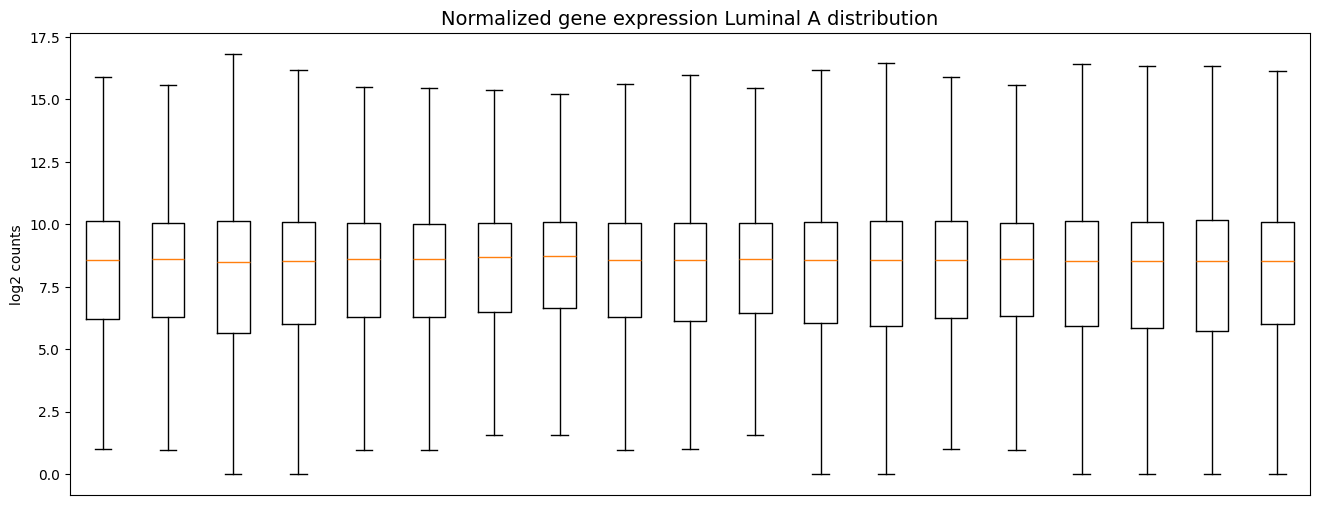

In [36]:
plt.figure(figsize=(16,6))
plt.boxplot(np.log2(normal_counts_luminal_A[1:20].T + 1), showfliers=False)
plt.xticks([])
plt.title("Normalized gene expression Luminal A distribution", fontsize=14)
plt.ylabel("log2 counts")
plt.show()

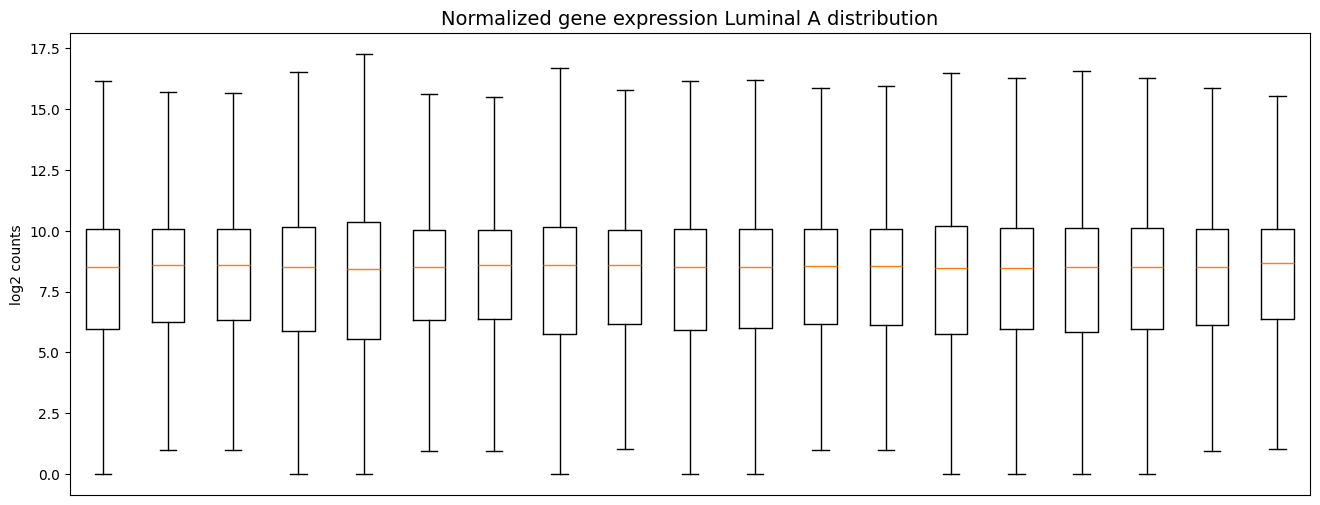

In [37]:
plt.figure(figsize=(16,6))
plt.boxplot(np.log2(normal_counts_luminal_B[1:20].T + 1), showfliers=False)
plt.xticks([])
plt.title("Normalized gene expression Luminal A distribution", fontsize=14)
plt.ylabel("log2 counts")
plt.show()

Histograms after the initialization

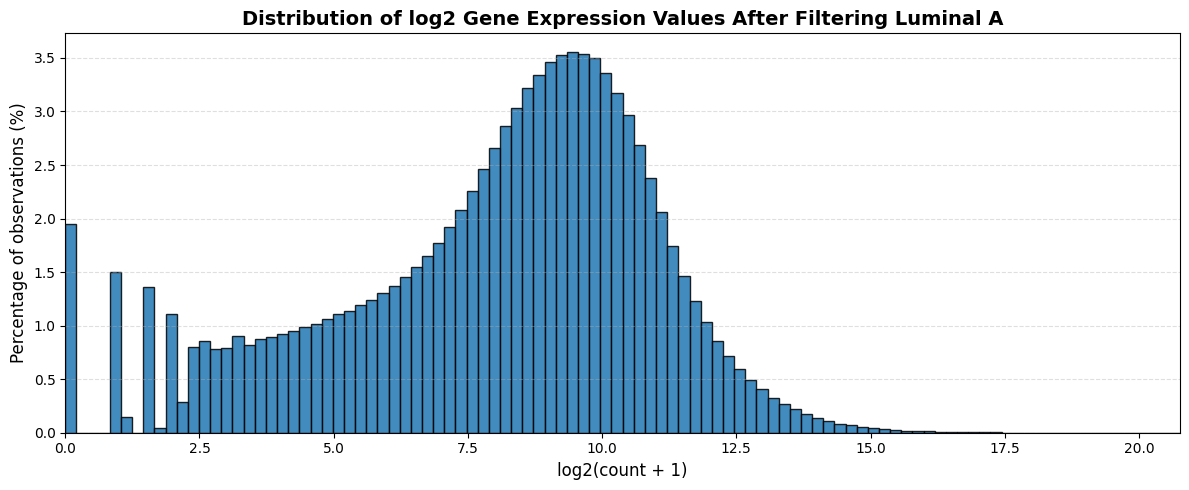

In [38]:
x = np.log2(normal_counts_luminal_A.ravel() + 1) # type: ignore
counts, bins = np.histogram(x, bins=100)
counts_percentage = (counts / counts.sum()) * 100
bin_width = bins[1] - bins[0]

plt.figure(figsize=(12,5))

plt.bar(
    bins[:-1],
    counts_percentage,
    width=bin_width,
    edgecolor="black",
    alpha=0.85,
    align="edge"
)
plt.title(
    "Distribution of log2 Gene Expression Values After Filtering Luminal A",
    fontsize=14,
    fontweight="bold"
)

plt.xlabel("log2(count + 1)", fontsize=12)
plt.ylabel("Percentage of observations (%)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xlim(0, np.max(bins))
plt.tight_layout()

plt.show()

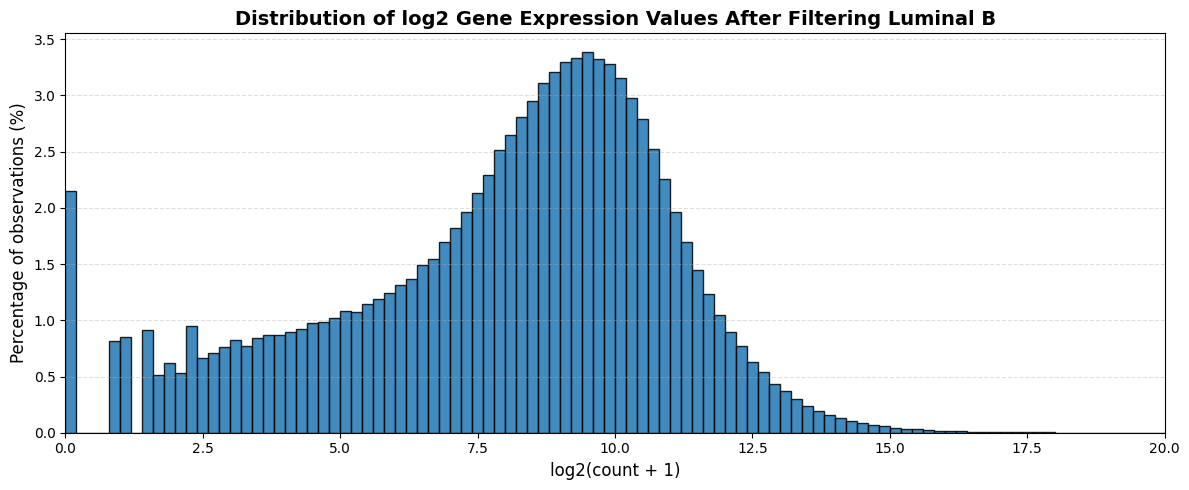

In [39]:
x = np.log2(normal_counts_luminal_B.ravel() + 1) # type: ignore
counts, bins = np.histogram(x, bins=100)
counts_percentage = (counts / counts.sum()) * 100
bin_width = bins[1] - bins[0]

plt.figure(figsize=(12,5))

plt.bar(
    bins[:-1],
    counts_percentage,
    width=bin_width,
    edgecolor="black",
    alpha=0.85,
    align="edge"
)
plt.title(
    "Distribution of log2 Gene Expression Values After Filtering Luminal B",
    fontsize=14,
    fontweight="bold"
)

plt.xlabel("log2(count + 1)", fontsize=12)
plt.ylabel("Percentage of observations (%)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xlim(0, np.max(bins))
plt.tight_layout()

plt.show()

In [40]:
norm_counts[mask_luminal_b]

array([[   7.08490261,  120.44334433,   80.97031551, ..., 1196.33641171,
        1471.63548445, 1183.17873544],
       [   1.971324  ,   68.99633998,   44.35478999, ...,  995.51861968,
         706.71965377, 1687.45334345],
       [  13.69584797,  136.9584797 ,  345.33102381, ..., 1351.97584959,
         551.74701821,  152.61087738],
       ...,
       [   0.        ,  120.66115865,  155.30644182, ...,  439.63669685,
         179.19974057,   35.83994811],
       [   1.98238407,   99.11920362,  363.76747728, ...,  955.50912289,
         503.52555439,   16.85026462],
       [   5.79593395,  198.99373237,   99.49686619, ..., 1114.75129688,
         477.19856209,   70.51719642]], shape=(81, 16298))

In [41]:
mask_a = np.asarray(mask_luminal_a)   # (n_samples,)
mask_b = np.asarray(mask_luminal_b) # (n_samples,)


Xa = norm_counts[mask_a, :]  # Luminal A
Xb = norm_counts[mask_b, :]  # Luminal B

X = np.vstack([Xa, Xb])
y = np.array(["Luminal A"] * Xa.shape[0] + ["Luminal B"] * Xb.shape[0])


X_log = np.log2(X + 1)
X_scaled = StandardScaler().fit_transform(X_log)


pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)


df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_plot["Subtype"] = y

fig = px.scatter(
    df_plot, x="PC1", y="PC2", color="Subtype",
    title="PCA de normed_counts (log2 + 1): Luminal A vs Luminal B",
    labels={
        "PC1": f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
        "PC2": f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
    }
)
fig.show()

In [42]:
inference = DefaultInference(n_cpus=2)
deseq_stats_test = DeseqStats(deseqDataSet_variable, contrast=["Tumor_Cancer", "Luminal A", "Luminal B",], inference=inference)

Running Wald tests...
... done in 4.56 seconds.



Log2 fold change & Wald test p-value: Tumor_Cancer Luminal A vs Luminal B
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0         6.186103       -0.132416  0.121436 -0.266937  0.789517  1.000000
1       106.679342       -0.013318  0.066297  0.000000  1.000000  1.000000
2       220.017210        0.221973  0.115340  1.057503  0.290282  0.850742
7         5.933969        0.085251  0.100323  0.000000  1.000000  1.000000
14      446.419891       -0.029254  0.141984  0.000000  1.000000  1.000000
...            ...             ...       ...       ...       ...       ...
20434   909.922038        0.030916  0.052761  0.000000  1.000000  1.000000
20435  3470.136970       -0.099445  0.077975  0.000000  1.000000  1.000000
20436  1310.000652        0.171371  0.067753  1.053402  0.292157  0.854400
20437   974.775820        0.158551  0.070525  0.830215  0.406417  1.000000
20438   188.571667       -0.188038  0.225258 -0.390832  0.695922  1.000000

[16298 rows x 6 columns]


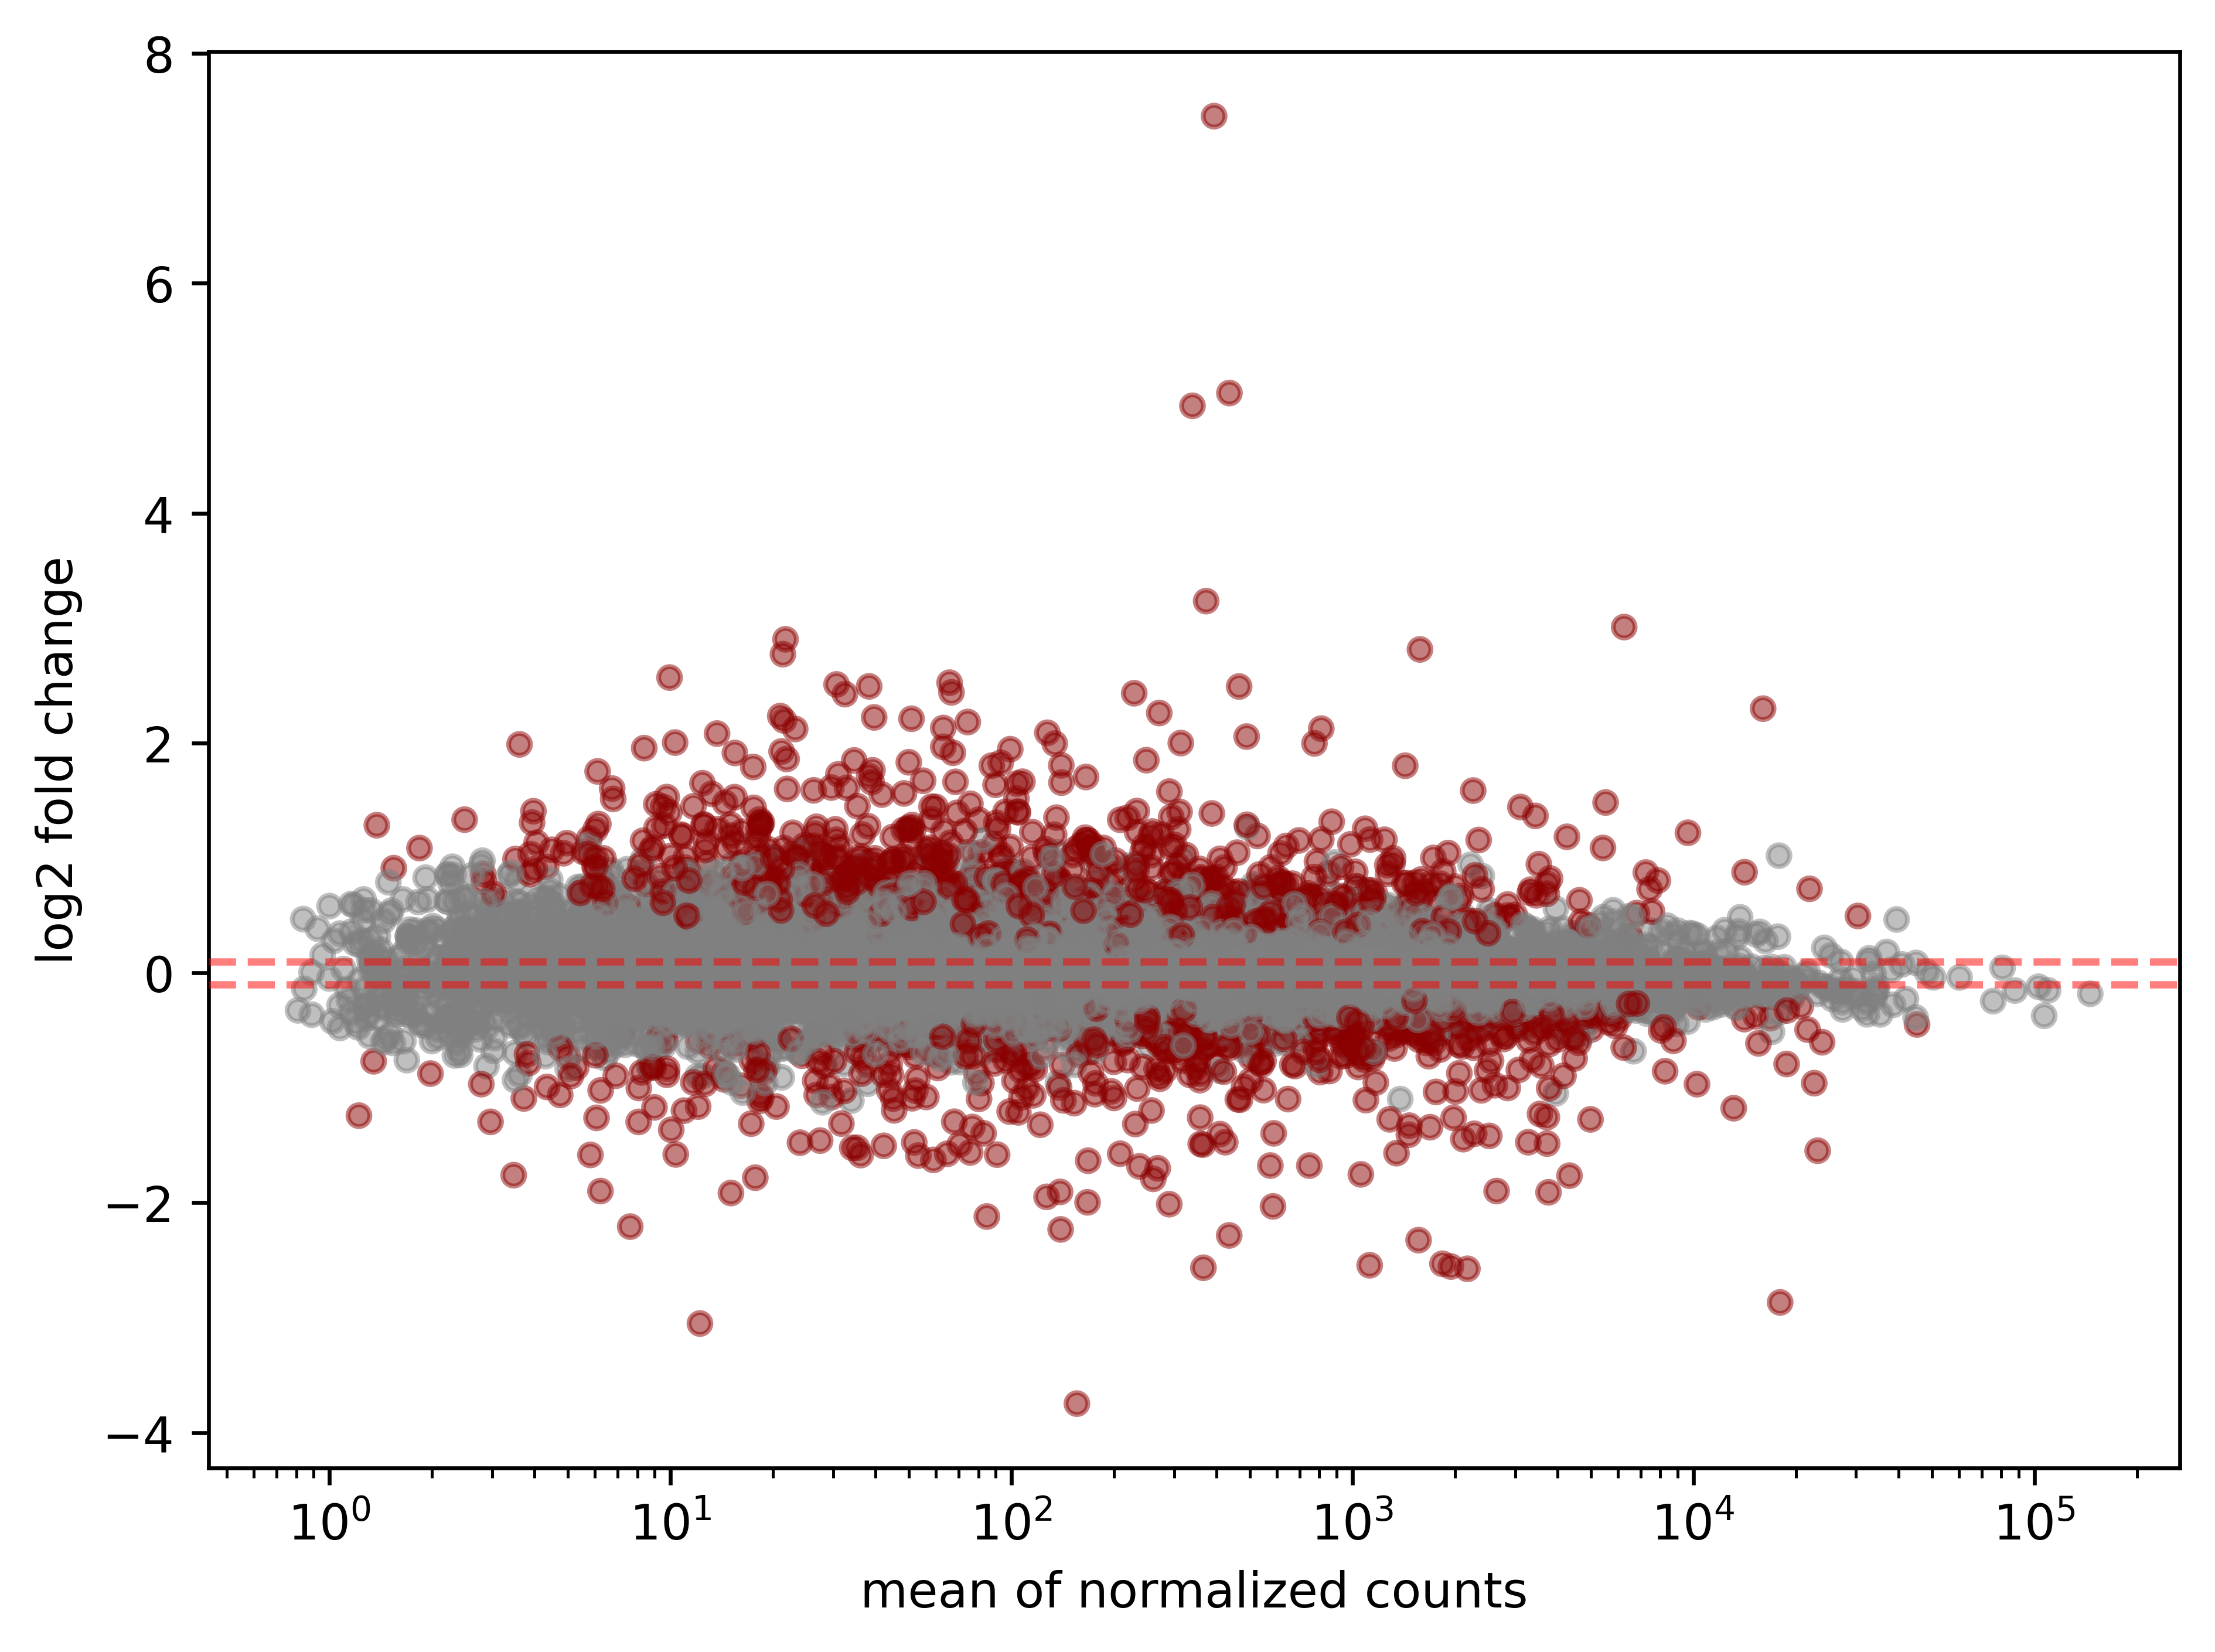

In [43]:
deseq_stats_test.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
deseq_stats_test.plot_MA(s=20)

In [44]:
print(type(deseqDataSet_variable))
deseqDataSet_variable_df = pd.DataFrame(deseqDataSet_variable.layers["normed_counts"])
print(type(deseqDataSet_variable_df))



<class 'pydeseq2.dds.DeseqDataSet'>
<class 'pandas.core.frame.DataFrame'>


In [45]:
deseqDataSet_variable_df

,0,1,2,3,4,5,6,7,8,9,...,16288,16289,16290,16291,16292,16293,16294,16295,16296,16297
0,3.891982,148.868320,72.001671,4.864978,290.925672,463.145885,97.299556,186.815147,68.109689,0.000000,...,788.126402,92.434578,706.394775,990.509478,55.460747,934.075735,2925.797642,900.993886,1045.970225,842.614153
1,4.034206,135.145901,63.538745,4.034206,641.438755,394.343637,4.034206,227.932639,131.111695,0.000000,...,423.591631,83.709775,2754.354151,841.131952,51.436127,1101.338240,3057.928153,966.192338,724.139978,43.367715
2,7.084903,120.443344,80.970316,5.060645,185.219597,502.015956,26.315353,310.723586,103.237152,0.000000,...,511.125117,60.727737,552.622403,1026.298749,39.473029,1427.101811,4625.429274,1196.336412,1471.635484,1183.178735
3,5.803639,104.465496,211.832811,9.672731,189.585530,566.822043,53.200021,177.010979,122.843685,0.000000,...,480.734736,63.840025,355.956505,1046.589507,42.560017,760.276666,2476.219165,1040.785868,865.709435,89.956399
4,11.469321,124.077199,273.178370,10.426655,922.758998,416.023548,15.639983,217.917097,69.858591,0.000000,...,1211.577351,110.522547,3357.383020,1398.214482,83.413243,847.687079,3112.356620,679.817928,460.858166,237.727742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,14.092635,117.774164,309.031355,3.019850,157.032219,473.109892,78.516110,501.295162,62.410241,6.039701,...,1171.701944,77.509493,543.573067,1198.880598,347.282793,843.544870,2739.004287,1255.251138,1100.232152,25.165420
407,6.840754,146.587580,527.715286,5.863503,212.063365,607.849830,61.566783,353.764692,140.724076,0.977251,...,287.311656,77.202792,432.921985,1058.362324,39.090021,838.480955,4817.845115,2161.678173,649.871603,243.335382
408,2.001020,115.058674,338.172450,4.002041,402.205104,943.481126,18.009184,51.026021,160.081633,0.000000,...,536.273472,45.022959,747.381125,903.460718,10.005102,634.323472,4165.123996,1251.638270,773.394391,5.002551
409,4.910909,121.790551,317.244741,4.910909,1118.705140,533.324751,21.608001,262.242557,38.305093,1.964364,...,456.714566,44.198184,782.798944,1019.504772,12.768364,670.830211,5123.060590,1382.912061,700.295667,556.897115


In [46]:
z_counts = deseqDataSet_variable_df.apply(zscore, axis=1) # type: ignore
print(z_counts)

        0         1         2         3         4         5         6      \
0   -0.287648 -0.250414 -0.270156 -0.287398 -0.213930 -0.169699 -0.263659   
1   -0.334883 -0.298541 -0.318390 -0.334883 -0.158205 -0.226696 -0.334883   
2   -0.210078 -0.192087 -0.198352 -0.210400 -0.181806 -0.131526 -0.207026   
3   -0.245110 -0.223442 -0.199862 -0.244260 -0.204748 -0.121898 -0.234701   
4   -0.135523 -0.122923 -0.106240 -0.135640 -0.033556 -0.090256 -0.135056   
..        ...       ...       ...       ...       ...       ...       ...   
406 -0.369056 -0.332240 -0.264327 -0.372988 -0.318300 -0.206064 -0.346180   
407 -0.253595 -0.221919 -0.135531 -0.253816 -0.207078 -0.117367 -0.241190   
408 -0.155518 -0.140009 -0.109401 -0.155244 -0.100617 -0.026362 -0.153322   
409 -0.332343 -0.296797 -0.237355 -0.332343  0.006388 -0.171640 -0.327265   
410 -0.283529 -0.256637 -0.138526 -0.284056 -0.001169 -0.052579 -0.240555   

        7         8         9      ...     16288     16289     16290  \
0  

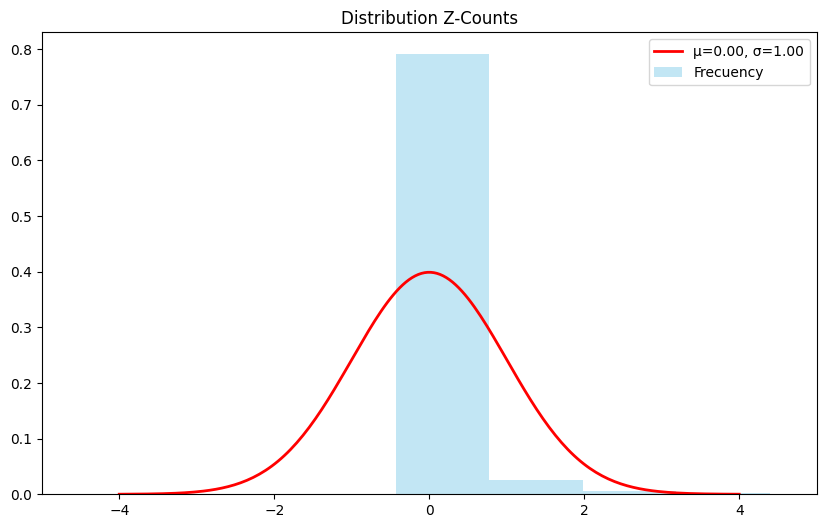

In [47]:
data = z_counts.values.ravel()


mu = np.nanmean(data) 
std = np.nanstd(data)

counts, bins = np.histogram(data, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bins[1]-bins[0]), color='skyblue', alpha=0.5, label='Frecuency')

x = np.linspace(mu - 4*std, mu + 4*std, 200)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', lw=2, label=f'μ={mu:.2f}, σ={std:.2f}')

plt.title("Distribution Z-Counts")
plt.xlim(-5, 5)
plt.legend()
plt.show()

In [48]:
upper_outliers = np.sum(data > 3)
down_outliers = np.sum(data < -3)
total = len(data)
print(f"total of data: {total}")
print(f"Outliers Upper (>3): {upper_outliers} ({100*upper_outliers/total:.4f}%)")
print(f"Outliers Down (<-3): {down_outliers} ({100*down_outliers/total:.4f}%)")

total of data: 6698478
Outliers Upper (>3): 58436 (0.8724%)
Outliers Down (<-3): 0 (0.0000%)
